# zip 파일 풀기
처리 완료했으므로 주석처리

In [1]:
# import os
# ziplist = os.listdir('./kfood')

In [2]:
# import zipfile
# for i in ziplist:
# 	#zip 파일 위치
#     path_to_zip_file = f'./kfood/{i}'
# 	#저장할 경로
#     directory_to_extract_to = './data'
#     with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#         zip_ref.extractall(directory_to_extract_to)

# Import

In [1]:
import os
from PIL import Image

import math
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2

import tensorflow.keras.backend as K

import random
import shutil #파일 복사

import warnings
warnings.filterwarnings(action='ignore')
print('keras ', keras.__version__)
print('tensorflow', tf.__version__)

keras  2.4.0
tensorflow 2.4.0


# Flow
<br>

1. local에서 원본 데이터 폴더 내 이미지를 train, validation, test 세 폴더로 데이터 분리
2. 이미지 EDA 및 전처리
3. 이미지 분류 CNN 모델 중 하나인 InceptionV3 모델을 활용한 한식 이미지 분류 CNN 모델 만들기
4. validation set에서 모델 평가 (기준 : accuracy, confusion_matrix 시각화)
5. test set에서 accuracy 최종 확인
6. h5 model을 tflite 모델로 변환
7. FireBase에 모델 올릴 때 용량 제한 문제 발생 
8. 가벼운 용량의 MobileNetV2 모델로 (4, 5, 6, 7 과정 재 수행)


### Summary

A) InceptionV3 기반 모델
- `max accuracy` : train -> %, val -> %, test -> % 
- 모델 용량 : h5 model : , tflite model :  
B) MobileNetV2  기반 모델
- `max accruacy` : train -> %, val -> %, test -> % 
- 모델 용량 : h5 model : , tflite model :   
---

# train, validation, test 분리
local에서 원본 데이터 폴더 내 이미지를 train, validation, test 세 폴더로 데이터 분리
<br>
원본 데이터 출처 : https://aihub.or.kr/aidata/13594 (AIHub) 의 한식 데이터
<br>
<b> 대분류 12개, 소분류 150개, 각 종류별 1000개의 데이터, 용량 15GB</b>

처리 완료했으므로 주석처리

In [7]:
# original_dataset_dir = './data/original'
# base_dir = './data'

# # os.mkdir(base_dir)

# train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)


# validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)

# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# random.seed = 42

# file_list = os.listdir(original_dataset_dir)
# #food list 저장하기 위해 빈리스트 생성
# food_list = []
# for each in file_list: # 대분류
#     big = os.path.join(original_dataset_dir, each)
#     big_class = os.listdir(big)
#     print(each)
#     for food_name in big_class: # 소분류
#         #food_list에 추가
#         food_list.append(food_name)
#         train_each = os.path.join(train_dir, food_name)
#         os.mkdir(train_each)
        
#         val_each = os.path.join(validation_dir, food_name)
#         os.mkdir(val_each)
        
#         test_each = os.path.join(test_dir, food_name)
        
#         os.mkdir(test_each)
        
#         small_list = os.path.join(big, food_name)
        
#         foods = os.listdir(small_list)
        
#         for i, each_food in enumerate(foods):
#             if i == 0 or i == len(foods) - 1:
#                 continue  
#             if i <= 800: # train 80%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(train_each, each_food)
#                 shutil.copyfile(src, dst)
#             elif i <= 900: # val 10%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(val_each, each_food)
#                 shutil.copyfile(src, dst)
#             else: # test 10%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(test_each, each_food)
#                 shutil.copyfile(src, dst)
                
# print("음식 class 개수 : ", len(food_list)) 
            
            

In [2]:
food_list = os.listdir('./data/train')
len(food_list)

150

# EDA

In [3]:
# 경로 설정
base_dir = './data'
train_dir = os.path.join(base_dir, 'train' )
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 데이터 저장 경로 확인
print('train_dir === ', train_dir)
print('val_dir === ', val_dir)
print('test_dir === ', test_dir)

train_dir ===  ./data\train
val_dir ===  ./data\validation
test_dir ===  ./data\test


In [4]:
# 클래스의 이미지 랜덤하게 1개 보여주는 함수

import random
from matplotlib import pyplot as plt

def show_random_image_in_train_set(food_name):
    img_path = os.path.join(train_dir, food_name)
    imgs_list = os.listdir(img_path)
    img = random.choice(imgs_list)
    plt.imshow(plt.imread(os.path.join(img_path, img)))

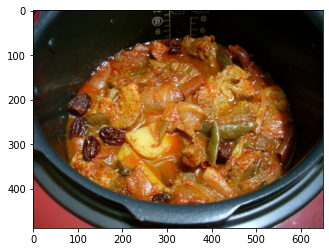

In [5]:
show_random_image_in_train_set("갈비찜")

# Data augmentation

이미지 분류에서 Overfitting을 막기 위한 방법으로, 모델에 넣을 때 이미지를 random하게 변형시키는 것

**`keras ImageDataGenerator`**
- `rescale` = 1./255 : 원본 그림은 0-255의 RGB 계수 - 이를 1/255로 스케일링하여 0-1범위로 변환. 이는 다른 전처리 과정에 앞서 가장 먼저 적용
- `rotation_range` : int, 무작위 회전의 각도 범위(degrees)
- `width_shift_range` : float, 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
- `height_shift_range` : float, 
- `shear_range` : float, 
- `zoom_range` : float, 무작위 줌의 범위
- `horizontal_flip` : boolean, input을 무작위로 가로로 뒤집는다.
- `fill_mode` : {"constant", "nearest", "reflect", "wrap"} , input 경계의 바깥 공간을 다음의 모드에 따라 다르게 채워진다.
  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
  - 'nearest': aaaaaaaa|abcd|dddddddd
  - 'reflect': abcddcba|abcd|dcbaabcd
  - 'wrap': abcdabcd|abcd|abcdabcd

https://keras.io/api/preprocessing/image/

In [6]:
# !pip install scipy

# Generator를 사용한 이미지 전처리

* 중요) train_datagen에 대해서만 augmentation을 수행한다!

generator를 사용하지 않으면 이미지 행렬이 모두 메모리 상에 올라가기 때문에 메모리 부족 현상이 발생할 수 있지만,

<b>generator는 연산에 사용되는 부분만 메모리에 올리기 때문에 메모리 효율적이다!</b>

`flow_from_directory()` <br>
인자로 설정해주는 directory의 바로 하위 디렉토리 이름을 레이블이라 간주하고 그 레이블이라고 간주한 디렉토리 아래의 파일들을 해당 레이블의 이미지들이라고 알아서 추측하여 Numpy Array Iterator를 생성하게 된다.
- target_size : 모델에 들어갈 인풋 이미지 사이즈 중 width, height를 입력
- batch_size : 이미지 데이터 원본 소스에서 한 번에 얼마만큼의 이미지를 가져올 것인지
- class_mode : ‘categorical’, ‘sparse’, ‘binary’

++ 'flow_from_dataframe()`도 존재 - pandas dataframe으로 저장

In [34]:
# 이미지의 각 픽셀을 255로 나눠주는 것은 필수!

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255) # 검증, 테스트 데이터는 augmentation 하면 안됨!
test_datagen = ImageDataGenerator(rescale= 1./255) 

IMAGE_SIZE = (224,224)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = 4, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = IMAGE_SIZE,
    batch_size = 4, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    shuffle=True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size = 4, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)
#resource exhausted 오류 발생으로 배치사이즈 8로 설정

Found 119920 images belonging to 150 classes.
Found 15000 images belonging to 150 classes.
Found 15593 images belonging to 150 classes.


In [35]:
# generator 출력 살펴보기
for data_batch, labels_batch in train_generator:
    print("배치 데이터 크기 : ", data_batch.shape)
    print("배치 레이블 크기 : ", labels_batch.shape)
    break

배치 데이터 크기 :  (4, 224, 224, 3)
배치 레이블 크기 :  (4, 150)


In [36]:
# generator의 길이
len(train_generator)

29980

# DenseNet


### 사용 가능한 자원(CPU/GPU) 확인

In [37]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4017738612889640533
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1408043828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5932385438539472830
physical_device_desc: "device: 0, name: GeForce MX250, pci bus id: 0000:3a:00.0, compute capability: 6.1"
]


### 파일 저장 경로 설정

In [38]:
#모델 저장 경로 설정
from datetime import datetime
today = datetime.today()
date ='{}.{}.{}.{}h'.format(today.year, today.month, today.day, today.hour)
print(date)

MODEL_SAVE_FOLDER_PATH = './model/DenseNet-{}/'.format(date)

if not(os.path.isdir(MODEL_SAVE_FOLDER_PATH)):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '결과 : {epoch:02d}-{val_acc:.4f}.hdf5'
print(model_path)

2022.2.15.14h
./model/DenseNet-2022.2.15.14h/결과 : {epoch:02d}-{val_acc:.4f}.hdf5


## DenseNet 모델에 image_generator 투입

- 원래 InceptionV3 층에서 마지막 층을 빼고 AveragePooling, Dropout, Flatten, Dropout, softmax 층을 추가! 

`glorot_uniform` : Glorot 균등분포 초기값 설정기, Xavier 균등분포 초기값 설정기라고도 한다.

In [39]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [41]:
from tensorflow.keras.applications import densenet

classes = 150
dense = densenet.DenseNet201(weights='imagenet',input_shape=(224,224,3), include_top=False)

In [42]:
for layer in dense.layers[:-2]:
    layer.trainable = False
for layer in dense.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000024BAE80D208> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000024BAE80D940> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AAE4B2CF8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024BAE692EB8> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024BAE7C9D30> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000024BAE80D6A0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000024BAE7C12B0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024BA77FCB38> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024BAE8C3EB8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AADB39E10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024AADAF8358> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024AADB08AC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AADE9EA90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024AADA93710> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024B89491CC0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AADDF4048> False
<tensorflow.python.keras.layers.merge.Concatenate object at 0x0000024B65A7BDA0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024AAE20A5C0> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024AADA95438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AAE298518> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000

<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024AAD900E48> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024AADA5CC50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AADA5C828> False
<tensorflow.python.keras.layers.merge.Concatenate object at 0x0000024AADA6C2B0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024AADA60550> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024AADA4E5F8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AADA5C9E8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000024AADA60D30> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000024AAD9006D8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000024AADA4E320> False
<tensorflow.python.keras.layers.merge.Concatenate object at 0x0000024AAD9B1780> Fal

In [43]:
from tensorflow.keras import models, layers
model = models.Sequential()

model.add(dense)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
Total params: 18,321,984
Trainable params: 3,840
Non-trainable params: 18,318,144
_________________________________________________________________


In [44]:
model.add(layers.AveragePooling2D(padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 1920)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              31458304  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)             

In [ ]:
# import tensorflow.keras.backend as K
# sess = K.get_session()
# init = tf.global_variables_initializer()
# sess.run(init)

In [45]:
# import tensorflow.keras.backend as K
# import tensorflow.keras.backend.tensorflow_backend as K
# K.clear_session()
# with tf.device('/device:CPU:0'): # gpu 사용
model.compile(
  optimizer=keras.optimizers.RMSprop(lr=0.01), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [48]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
    
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=1)
    
batch_stats = CollectBatchStats()
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only=True)

In [49]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              verbose=1,
                              callbacks=[batch_stats, checkpointer])

Epoch 1/10
   17/29980 [..............................] - ETA: 2:37:44 - loss: 7.1474 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

# 다른 방식 2
https://github.com/sejongresearch/FoodRecommender/blob/master/DenseNet_fine_arg_final.ipynb

In [66]:
import matplotlib.pylab as plt

import tensorflow as tf

!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

^C


In [40]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [49]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(299,299,3))

In [62]:
# 이미지의 각 픽셀을 255로 나눠주는 것은 필수!

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255) # 검증, 테스트 데이터는 augmentation 하면 안됨!
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 8, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 8, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    shuffle=True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 8, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)


Found 119920 images belonging to 150 classes.
Found 15000 images belonging to 150 classes.
Found 15593 images belonging to 150 classes.


In [63]:
# generator 출력 살펴보기
for data_batch, labels_batch in train_generator:
    print("배치 데이터 크기 : ", data_batch.shape)
    print("배치 레이블 크기 : ", labels_batch.shape)
    break

배치 데이터 크기 :  (8, 224, 224, 3)
배치 레이블 크기 :  (8, 150)


In [65]:
feature_batch = feature_extractor_layer(data_batch)
print(feature_batch.shape)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/Conv/Conv2D}}]] [Op:__inference_restored_function_body_96356]

Function call stack:
restored_function_body


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
#데이터 증식
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#분류 계층 추가
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dropout(0.2),
#   data_augmentation,
  layers.Dense(512, activation = 'relu'),
  layers.Dense(image_data.num_classes, activation = 'softmax')
])

model.summary()